In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv('boscun-longitudinal.csv')

### Problem Definition

For a given combination of fly dates (departure,return) and search date ${t_0}$ we want to establish if the user should
 - Wait: There exists a ${t}$, where ${t > t_0}$, for which t has a better price
 - Book now : There is no $t$, where ${t > t_0}$, for which t has a better price
 
We still need to define "better price". Two potential candidates are: 
 1. $min(price)$ : If we expect at least one flight with a cheaper rate than today's cheapest rate, we advise to wait
 2. $avg(price)$: If we expect to see, on average, cheaper prices than today's average rate, we advise to wait
 
I chose candidate (1), ${min(price)}$, as I expect that seeing a cheaper rate on a date in the future inspires user confidence in the product’s decision. In using ${avg(price)}$, it could happen that average prices go down, but not cheaper rate appears. This decision could be validated by conducting user research and identifying which definition inspires most trust in Hopper (and therefore could be a driver for customer lifetime value). 

### Preferred (not possible) Approach 
The first approach considered is to use time series modeling to forecast $min(price)$ for future search dates, given a departure and return date. The advice to book or wait, would be generated based on results of the forecast.

Pros: 
- This makes use of the dependency among previous observations to predict future behavior.

Cons: 
- Need to solve for a cold start problem, as we only get data once a search has been made
- In cases with few previous observations, we cannot forecast far ahead in the future.

With our dataset, this is _not possible_, because at least 50% of our departure-return date combinations only have 3 distinct search dates or less.



### Approach Chosen
Consider one observation to be a combination of a search date, departure date and return date (as this is the level at which we need predictions). Using those observations, I have decided to build a series of machine learning models, to predict “book” or “wait” as a classification problem, based on features we know at the search result stage. I then chose the best model (in terms of accuracy), and use it to make predictions. Below the pros and cons of this approach

Pros: 
 - Avoids cold start problem
 
Cons:
 - Not making use of the information that lies in historical searches to inform future prices
 - This violates the IID assumption required for some those models (i.e. logistic regression)



### Descriptive Statistics & Data Validation

In [3]:
#Check for missing values
df.count()

search_id                       3009408
trip_index                      3009408
received_date                   3009408
received_ms                     3009408
origin                          3009408
destination                     3009408
total_usd                       3009408
pax_type                        2654847
refundable                            0
validating_carrier              2654847
departure_odate                 3009408
departure_ms                    3009408
outgoing_duration               3009408
outgoing_stops                  3009408
return_odate                    3009408
return_ms                       3009408
returning_duration              3009408
returning_stops                 3009408
major_carrier_id                3009408
total_stops                     3009408
advance                         3009408
length_of_stay                  3009408
includes_saturday_night_stay    3009408
available_seats                 3009408
lowest_cabin_class              3009408


In [4]:
#Refundable is always missing
df[df['refundable'].isnull() == False]

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class


In [5]:
#Unique Searches, on average 26 results per search
len(df.search_id.unique())

113339

In [6]:
#All Flights are BOS-CUN
print(len(df[df['origin']!="BOS"]))
print(len(df[df['destination']!="CUN"]))

0
0


In [7]:
#Price Range is realistic
print("Price Range is " + str(df['total_usd'].min()) + " to " + str(df['total_usd'].max()))

Price Range is 224.08 to 8382.24


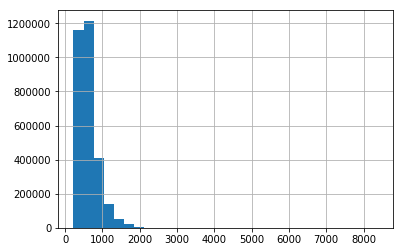

In [8]:
#Price Distribution
df['total_usd'].hist(bins = 30)
plt.show()

In [9]:
#Only Adults and Missing PAX Types
df.pax_type.unique()

array(['ADT', nan], dtype=object)

In [10]:
#Carrier is missing at same time as PAX Type is missing
df[df['pax_type'].isnull() & (df['validating_carrier'].isnull() == False)]

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class


In [11]:
#Validating total stops
df[(df['outgoing_stops'] + df['returning_stops'])!= df['total_stops']]

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class


In [12]:
#Nothing seems unusual in the descriptives of continuous variables 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_index,3009408.00,93.63,55.72,0.00,45.00,92.00,140.00,387.00
received_ms,3009408.00,1465045573343.01,12504702245.11,1437280080059.00,1454873531678.00,1466179695191.00,1476614054571.00,1483246056851.00
total_usd,3009408.00,614.84,276.06,224.08,421.89,565.58,725.93,8382.24
refundable,0.00,nan,nan,nan,nan,nan,nan,nan
departure_ms,3009408.00,1472220575940.61,13864783856.94,1437337200000.00,1460374200000.00,1473852600000.00,1483407000000.00,1510187100000.00
outgoing_duration,3009408.00,617.30,265.68,256.00,425.00,533.00,700.00,2070.00
outgoing_stops,3009408.00,1.12,0.38,0.00,1.00,1.00,1.00,3.00
return_ms,3009408.00,1472786245942.58,13870298268.54,1437825600000.00,1460979000000.00,1474394940000.00,1483908060000.00,1511053500000.00
returning_duration,3009408.00,617.34,248.40,178.00,446.00,533.00,695.00,2140.00
returning_stops,3009408.00,1.07,0.35,0.00,1.00,1.00,1.00,3.00


### Data Preprocessing

In [13]:
#Function for period of day
def period_of_day(row):
    hour_part =  row.hour
    if hour_part < 12: period = "morning"
    elif (hour_part >=12) & (hour_part <18): period = "afternoon"
    elif hour_part >= 18: period = "evening"
    return period

In [14]:
df_clean = df.fillna({'pax_type':'missing', 'validating_carrier':'missing'})\

#For convenience
df_clean.loc[:,'departure_dt'] = pd.to_datetime(df['departure_ms'], unit = 'ms')
df_clean.loc[:,'return_dt'] = pd.to_datetime(df['return_ms'], unit = 'ms')

df_clean.loc[:,'departure_date'] = df_clean['departure_dt'].dt.date
df_clean.loc[:,'return_date'] = df_clean['return_dt'].dt.date

#Adding period of day
df_clean.loc[:,'departure_period'] = df_clean['departure_dt'].apply(period_of_day)
df_clean.loc[:,'return_period'] = df_clean['return_dt'].apply(period_of_day)

#Transforming outgoing minutes into hours for easier interpretation
df_clean.loc[:,'outgoing_hours'] = df_clean['outgoing_duration']/60
df_clean.loc[:,'returning_hours'] = df_clean['returning_duration']/60

#Transformating departure date into days since the first departure date in the dataset, to facilitate interpretation
df_clean.loc[:,'departure_days'] = (df_clean['departure_dt'] - dt.datetime(2015,7,19,0,0,0)).apply(lambda x: x.days)

#Adding seasonality features
df_clean.loc[:,'departure_dayofweek'] = df_clean['departure_dt'].apply(lambda x: x.dayofweek)
df_clean.loc[:,'departure_month'] = df_clean['departure_dt'].apply(lambda x: x.month)

In [15]:
#Validating Length of Stay Columns
df_clean.loc[:,'validation_los'] = (df_clean['departure_dt'] + 
                                    pd.to_timedelta(df_clean['length_of_stay'], unit = 'days') -
                                    df_clean['return_dt']).apply(lambda x: x.total_seconds()/(60*60))

df_clean[abs(df_clean['validation_los'])>24]

,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,validating_carrier,...,departure_date,return_date,departure_period,return_period,outgoing_hours,returning_hours,departure_days,departure_dayofweek,departure_month,validation_los


In [16]:
#Validating that departure timestamps make sense
#Odd departure time at 11h01, and 9h48.
df_clean[['departure_dt']].head()

,departure_dt
0,2016-06-02 11:01:00
1,2016-06-02 11:10:00
2,2016-06-02 11:10:00
3,2016-06-02 09:48:00
4,2016-06-02 09:55:00


##### A Note on Cabin Classes

* B economy
* E economy premium
* EP possibly also maps to economy premium
* F first class
* U first class on AmericanAirlines, but Economy on Air Canada

As these can change depending on the airline, they will not be included in the model. If we could come up with an accurate mapping of classes, we could include them as an ordinal feature.

### Data Aggregation and Label Creation

In [17]:
#As we need to make our prediction for a given combination of search date, departure date, and return date, 
#we need to build our model for this level of granularity.

df_agg = df_clean.groupby(['advance','departure_days','length_of_stay',
                           'includes_saturday_night_stay', 'departure_month', 
                           'departure_dayofweek'])\
                 .agg({'search_id': ['count','nunique'],
                       'total_usd': ['min','mean','std'],
                       'pax_type' : 'nunique',
                       'validating_carrier' : 'nunique',
                       'departure_period': 'nunique',
                       'return_period': 'nunique',
                       'outgoing_hours': 'mean',
                       'returning_hours': 'mean',
                       'outgoing_stops': 'mean',
                       'returning_stops': 'mean',
                       'major_carrier_id' : 'nunique',
                       'available_seats': ['min','max','mean']
                 }).reset_index()

In [18]:
#Fixing column names
df_agg.columns = ['_'.join(df_agg.columns.ravel()[i]) for i in range(0, len(df_agg.columns))]

In [19]:
#When only one price is shown, standard deviation is 0
df_agg = df_agg.fillna({'total_usd_std':0})

#### Adding the True Label
Using the following rules:
- When advance == 0, always book now
- When advance > 0, look at min_price for all advance values smaller than the one of that row:
    - If min_price is smaller than min_price of current row then Wait
    - If min_price is larger than min_price of current row then Book Now

In [20]:
df_agg = (df_agg.assign(price_cum_min=df_agg.sort_values(['advance_'])\
                                .groupby(['departure_days_', 'length_of_stay_'])\
                                .total_usd_min\
                                .cummin()))

In [21]:
def true_label(row):
    #Book is 1
    #Wait is 0
    if row['advance_'] == 0: result = 1
    elif row['total_usd_min'] == row['price_cum_min']: result = 1
    elif row['total_usd_min'] > row['price_cum_min']: result = 0
    return result

In [22]:
df_agg.loc[:,'label'] = df_agg.apply(true_label, axis = 1)

In [23]:
df_agg.groupby('label').agg({'departure_days_':'count'})

,departure_days_
label,
0,65930
1,18627


In [24]:
#Classes are unbalanced
#Base Accuracy, if we tell everyone to wait
65930 /(65930 + 18627)

0.7797107276748229

### Understanding our Data Better

#### Continuous variables

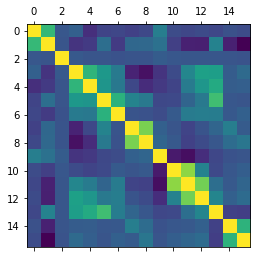

In [25]:
df_continuous = df_agg[['advance_', 'departure_days_', 'length_of_stay_', 'departure_period_nunique',
                    'return_period_nunique','search_id_count', 'search_id_nunique','returning_hours_mean',
                    'outgoing_hours_mean', 'available_seats_mean', 'total_usd_min', 'total_usd_mean',
                    'total_usd_std', 'validating_carrier_nunique', 'returning_stops_mean', 
                    'outgoing_stops_mean']]

plt.matshow(df_continuous.corr())
plt.show()

#### Categorical/Ordinal variables

In [26]:
df_agg.groupby('includes_saturday_night_stay_').agg({'advance_':'count'})

,advance_
includes_saturday_night_stay_,
False,11968
True,72589


In [27]:
df_agg.groupby('departure_month_').agg({'advance_':'count'})

,advance_
departure_month_,
1,6872
2,10594
3,8633
4,7570
5,5481
6,4568
7,4437
8,6306
9,5285


In [28]:
df_agg.groupby('departure_dayofweek_').agg({'advance_':'count'})

,advance_
departure_dayofweek_,
0,9597
1,8660
2,10635
3,13069
4,15482
5,16239
6,10875


### Building Prediction Models 

In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import warnings
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

### Correcting for Class Imbalance, with Oversampling

In [30]:
#Let's try to correct for class imbalance by oversampling the minority class
X = df_agg.drop('label', axis=1)
y = df_agg['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
all_train = pd.concat([X_train, y_train], axis = 1)

In [32]:
df_agg_wait = all_train[all_train['label'] == 0]
df_agg_book = all_train[all_train['label'] == 1]

In [33]:
df_agg_book_over = df_agg_book.sample(n=df_agg_wait['advance_'].count(), replace = True)
df_agg_over = pd.concat([df_agg_wait, df_agg_book_over], axis = 0)

In [34]:
X_train_over = df_agg_over.drop('label', axis=1)
y_train_over = df_agg_over['label']

### Creating Pipeline

In [35]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['advance_', 'departure_days_', 'length_of_stay_', 'departure_period_nunique',
                    'return_period_nunique','search_id_count', 'search_id_nunique','returning_hours_mean',
                    'outgoing_hours_mean', 'available_seats_mean', 'total_usd_min', 'total_usd_mean',
                    'total_usd_std', 'validating_carrier_nunique', 'returning_stops_mean', 
                    'outgoing_stops_mean']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['includes_saturday_night_stay_']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


ordinal_features = ['departure_month_', 'departure_dayofweek_']
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

### Fitting a Few Models

In [37]:
models = [LogisticRegression(C=10000), 
          LogisticRegression(penalty = 'l1', C= 0.001),
          LogisticRegression(penalty = 'l1', C= 0.01),
          LogisticRegression(penalty = 'l1', C= 0.1),
          AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), 
                             learning_rate=0.01, n_estimators=50),
          AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1), 
                             learning_rate=0.01, n_estimators=500),
          AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=3), 
                             learning_rate=0.01, n_estimators=500),
          RandomForestClassifier(n_estimators=500, max_depth = 9, max_features="sqrt"),
          RandomForestClassifier(n_estimators=500, max_depth = 12, max_features="sqrt"),
          RandomForestClassifier(n_estimators=500, max_depth = 15, max_features="sqrt"),
          SVC(kernel="linear", C=0.01),
          SVC(kernel="linear", C=0.1),
          SVC(gamma='scale', kernel='rbf', C=0.01),
          SVC(gamma='scale', kernel='rbf', C=0.1)
         ]

model_names = ['logistic_reg', 'lasso_reg_0.001', 'lasso_reg_0.01',
               'lasso_reg_0.1', 'adaboost_50_1', 'adaboost_500_1',
               'adaboost_500_3', 'rand_forest_9', 'rand_forest_12',
               'rand_forest_15','SVM_linear_0.01', 'SVM_linear_0.1',
               'SVM_rbf_0.01', 'SVM_rbf_0.1']


for i in range(0,15): 
    clf = Pipeline(steps=[('preprocessor', preprocessor), (model_names[i],models[i])])
    clf.fit(X_train_over, y_train_over)  

    scores = cross_val_score(clf, X_train_over, y_train_over, cv=5)
    print(model_names[i])
    print("Accuracy: %0.5f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print("\n")

logistic_reg
Accuracy: 0.69659 (+/- 0.0086)


lasso_reg_0.001
Accuracy: 0.69337 (+/- 0.0082)


lasso_reg_0.01
Accuracy: 0.69750 (+/- 0.0092)


lasso_reg_0.1
Accuracy: 0.69689 (+/- 0.0084)


adaboost_50_1
Accuracy: 0.68758 (+/- 0.0079)


adaboost_500_1
Accuracy: 0.73953 (+/- 0.0056)


adaboost_500_3
Accuracy: 0.78549 (+/- 0.0041)


rand_forest_9
Accuracy: 0.81025 (+/- 0.0050)


rand_forest_12
Accuracy: 0.85213 (+/- 0.0055)


rand_forest_15
Accuracy: 0.90093 (+/- 0.0064)


SVM_linear_0.01
Accuracy: 0.69775 (+/- 0.0091)


SVM_linear_0.1
Accuracy: 0.69793 (+/- 0.0090)


SVM_rbf_0.01
Accuracy: 0.71060 (+/- 0.0087)


SVM_rbf_0.1
Accuracy: 0.75203 (+/- 0.0088)




IndexError: list index out of range

### Investigating most successful models: Random Forests

#### Random forest with depth of 15 is overfitted

In [38]:
clf = Pipeline(steps=[('preprocessor', preprocessor), ('rand_for',RandomForestClassifier(max_depth = 15,n_estimators=500, max_features="sqrt"))])
clf.fit(X_train_over, y_train_over)  

scores = cross_val_score(clf, X_train_over, y_train_over, cv=5)
print("Accuracy: %0.5f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90113 (+/- 0.0060)


In [39]:
#Accuracy of chosen model
clf = Pipeline(steps=[('preprocessor', preprocessor), ('rand_for',RandomForestClassifier(max_depth = 15,n_estimators=500, max_features="sqrt"))])
clf.fit(X_train_over, y_train_over)  
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.856


#### Random forest with depth of 12 is chosen as our final model

In [40]:
clf = Pipeline(steps=[('preprocessor', preprocessor), ('rand_for',RandomForestClassifier(max_depth = 12,n_estimators=500, max_features="sqrt"))])
clf.fit(X_train_over, y_train_over)  

scores = cross_val_score(clf, X_train_over, y_train_over, cv=5)
print("Accuracy: %0.5f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85195 (+/- 0.0058)


In [41]:
#Accuracy of chosen model
clf = Pipeline(steps=[('preprocessor', preprocessor), ('rand_for',RandomForestClassifier(max_depth = 12,n_estimators=500, max_features="sqrt"))])
clf.fit(X_train_over, y_train_over)  
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.832


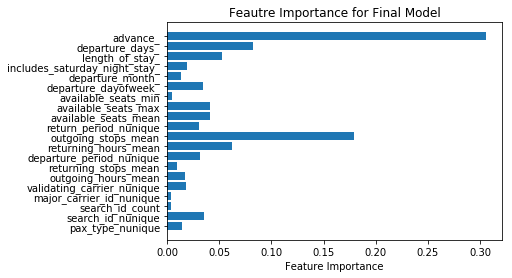

In [42]:
#Feature importance
importance = clf.steps[1][1].feature_importances_

fig, ax = plt.subplots()
y_pos = np.arange(len(importance))

ax.barh(y_pos, importance)
ax.set_yticks(y_pos)
ax.set_yticklabels(X_train_over.columns)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Feautre Importance for Final Model')

plt.show()

In [43]:
#Feature Importance Exact Values
for feat, importance in zip(X_train_over.columns, clf.steps[1][1].feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: advance_, importance: 0.30560443125005243
feature: departure_days_, importance: 0.08261279636854532
feature: length_of_stay_, importance: 0.052757765858743394
feature: includes_saturday_night_stay_, importance: 0.019120704971985137
feature: departure_month_, importance: 0.013391499713259845
feature: departure_dayofweek_, importance: 0.03454201366524228
feature: available_seats_min, importance: 0.0047858554189153515
feature: available_seats_max, importance: 0.04125423592221948
feature: available_seats_mean, importance: 0.041580748643632356
feature: return_period_nunique, importance: 0.030259396154752472
feature: outgoing_stops_mean, importance: 0.17874597347143945
feature: returning_hours_mean, importance: 0.06211126395505508
feature: departure_period_nunique, importance: 0.03181630928390228
feature: returning_stops_mean, importance: 0.009069003229176234
feature: outgoing_hours_mean, importance: 0.017265876802564212
feature: validating_carrier_nunique, importance: 0.01824229763

### Next Steps
As next steps, I would like to explore:
-	Optimizing further the model selection process, by tuning the models more extensively, via grid search.
-	Adding more features, such as external economics features, as well as interaction features, additional transformations of existing features (i.e. incorporating information on past searches, when available).
-	Building a model that predicts the date a user should wait until (for when the advice is to wait). The current version of Hopper already shows this, and it makes for a better user experience.
-	Investigate if multilevel models can help drive higher accuracy.
-	Create an accurate mapping for cabin classes and incorporate it in the model as an ordinal feature
